<a href="https://colab.research.google.com/github/miransikay/Evolutionary-Algorithm-Solution-for-the-Travelling-Salesman-Problem-TSP-/blob/main/Evolutionary_Algorithm_Solution_for_the_Travelling_Salesman_Problem_(TSP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Travelling Salesman Problem



In [ ]:
%%writefile evo.py
import numpy as np
from abc import ABC, abstractmethod


class Individual(ABC):
    def __init__(self, value=None, init_params=None):
        self.init_params = init_params
        self.value = value if value is not None else self._random_init(init_params)

    @abstractmethod
    def pair(self, other, pair_params):
        pass
    @abstractmethod
    def mutate(self, mutate_params):
        pass
    @abstractmethod
    def _random_init(self, init_params):
        pass


class Optimization(Individual):
    def pair(self, other, pair_params):
        return Optimization(pair_params['alpha'] * self.value + (1 - pair_params['alpha']) * other.value)

    def mutate(self, mutate_params):
        self.value += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])
        for i in range(len(self.value)):
            if self.value[i] < mutate_params['lower_bound']:
                self.value[i] = mutate_params['lower_bound']
            elif self.value[i] > mutate_params['upper_bound']:
                self.value[i] = mutate_params['upper_bound']

    def _random_init(self, init_params):
        return np.random.uniform(init_params['lower_bound'], init_params['upper_bound'], init_params['dim'])


class TSP(Individual):
    def pair(self, other, pair_params):
        self_head = self.value[:int(len(self.value) * pair_params['alpha'])].copy()
        self_tail = self.value[int(len(self.value) * pair_params['alpha']):].copy()
        other_tail = other.value[int(len(other.value) * pair_params['alpha']):].copy()

        mapping = {other_tail[i]: self_tail[i] for i in range(len(self_tail))}
        for i in range(len(self_head)):
            while self_head[i] in other_tail:
                self_head[i] = mapping[self_head[i]]

        child_value = np.hstack([self_head, other_tail])

        start_city = self.init_params.get("start_city", None)
        if start_city is not None and child_value[0] != start_city:
            idx = np.where(child_value == start_city)[0][0]
            child_value[0], child_value[idx] = child_value[idx], child_value[0]

        return TSP(child_value, init_params=self.init_params)

    def mutate(self, mutate_params):
        for _ in range(mutate_params['rate']):
            i, j = np.random.choice(range(len(self.value)), 2, replace=False)
            self.value[i], self.value[j] = self.value[j], self.value[i]

        start_city = self.init_params.get("start_city", None)
        if start_city is not None and self.value[0] != start_city:
            idx = np.where(self.value == start_city)[0][0]
            self.value[0], self.value[idx] = self.value[idx], self.value[0]

    def _random_init(self, init_params):
        route = np.random.choice(range(init_params['n_cities']), init_params['n_cities'], replace=False)

        start_city = init_params.get("start_city", None)
        if start_city is not None and route[0] != start_city:
            idx = np.where(route == start_city)[0][0]
            route[0], route[idx] = route[idx], route[0]
        return route


class Population:
    def __init__(self, size, fitness, individual_class, init_params):
        self.fitness = fitness
        self.individuals = [individual_class(init_params=init_params) for _ in range(size)]
        self.individuals.sort(key=lambda x: self.fitness(x))

    def replace(self, new_individuals):
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = self.individuals[-size:]

    def get_parents(self, n_offsprings):
        mothers = self.individuals[-2 * n_offsprings::2]
        fathers = self.individuals[-2 * n_offsprings + 1::2]
        return mothers, fathers


class Evolution:
    def __init__(self, pool_size, fitness, individual_class, n_offsprings, pair_params, mutate_params, init_params):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, fitness, individual_class, init_params)
        self.n_offsprings = n_offsprings

    def step(self):
        mothers, fathers = self.pool.get_parents(self.n_offsprings)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            offspring = mother.pair(father, self.pair_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        self.pool.replace(offsprings)


Writing evo.py


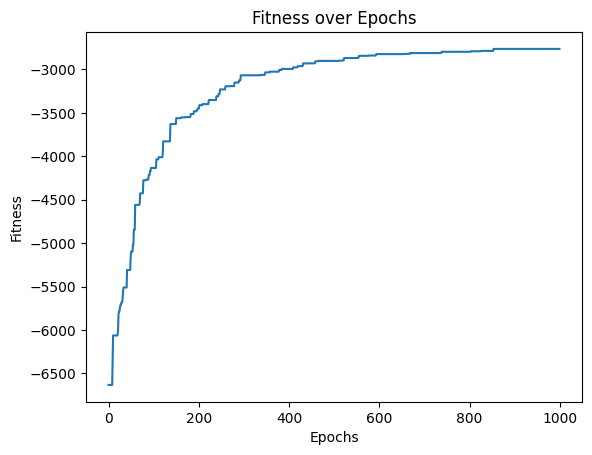

In [ ]:
import numpy as np
from evo import Evolution, TSP
import matplotlib.pyplot as plt


def tsp_fitness_creator(cities):
    matrix = []
    for city in cities:
        row = []
        for city_ in cities:
            row.append(np.linalg.norm(city - city_))
        matrix.append(row)
    distances = np.array(matrix)

    def fitness(tsp):
        res = 0
        for i in range(len(tsp.value)):
            res += distances[tsp.value[i], tsp.value[(i + 1) % len(tsp.value)]]
        return -res

    return fitness

def compute_distances(cities):
    distances = []
    for from_city in cities:
        row = []
        for to_city in cities:
            row.append(np.linalg.norm(from_city - to_city))
        distances.append(row)
    return np.array(distances)

def route_length(distances, route):
    length = 0
    for i in range(len(route)):
        length += distances[route[i], route[(i + 1) % len(route)]]
    return length

def plot_route(cities, route, distances):
    length = route_length(distances, route)

    plt.figure(figsize=(12, 8))
    plt.scatter(x=cities[:, 0], y=cities[:, 1], s=1000, zorder=1)
    for i in range(len(cities)):
        plt.text(cities[i][0], cities[i][1], str(i), horizontalalignment='center', verticalalignment='center', size=16,
                 c='white')
    for i in range(len(route)):
        plt.plot([cities[route[i]][0], cities[route[(i + 1) % len(route)]][0]],
                 [cities[route[i]][1], cities[route[(i + 1) % len(route)]][1]], 'k', zorder=0)
    if len(route) > 0:
        plt.title(f'{len(route)} city ​​visited, total distance: {length:.2f}', size=16)
    else:
        plt.title(f'{len(cities)} city', size=16)
    plt.show()

n_cities = 40
start_city = 12
np.random.seed(33)
cities = np.random.rand(n_cities, 2) * 400

fitness = tsp_fitness_creator(cities)
distances = compute_distances(cities)

evo = Evolution(
    pool_size=100,
    fitness=fitness,
    individual_class=TSP,
    n_offsprings=30,
    pair_params={'alpha': 0.5},
    mutate_params={'rate': 1},
    init_params={'n_cities': n_cities, 'start_city': start_city}
)
n_epochs = 1000

hist = []
for i in range(n_epochs):
    hist.append(evo.pool.fitness(evo.pool.individuals[-1]))
    evo.step()

plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Fitness')
plt.title('Fitness over Epochs')
plt.show()


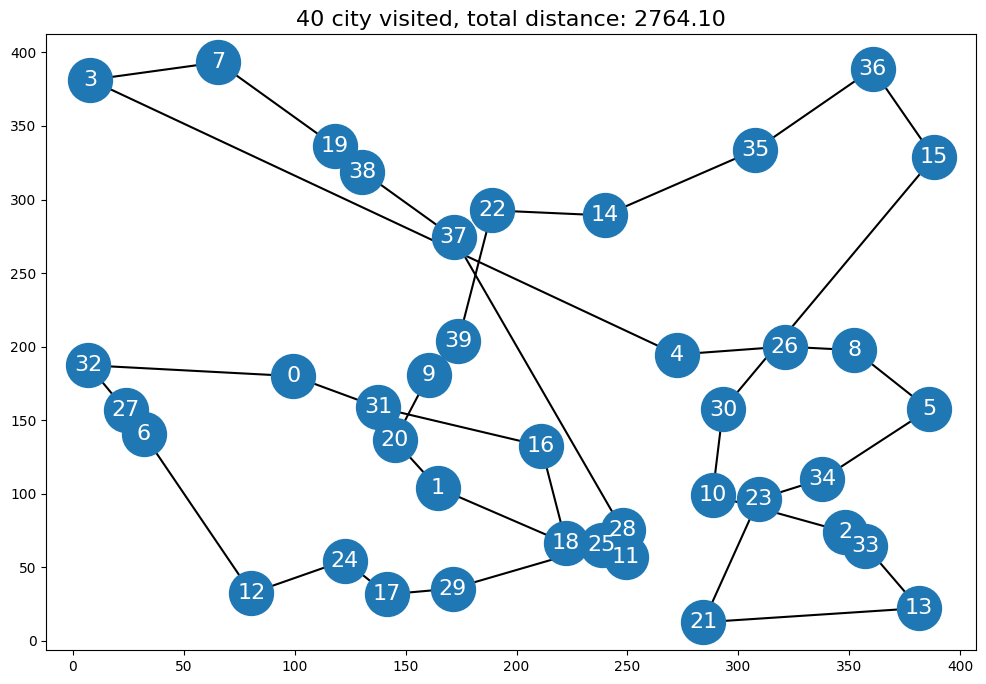

In [ ]:
plot_route(cities, route=evo.pool.individuals[-1].value, distances=distances)

In [ ]:
best_individual =evo.pool.individuals[-1]
print("Best route length:", route_length(distances, best_individual.value))

Best route length: 2764.098940284196


In [ ]:
print("Route order:", evo.pool.individuals[-1].value)


Route order: [12  6 27 32  0 31 16 18  1 20  9 39 22 14 35 36 15 30 10  2 33 13 21 23
 34  5  8 26  4  3  7 19 38 37 28 11 25 29 17 24]
